# Performing OCR on Segmented IC Chips

Here I will try to use Tesseract in order to read the characters from IC chips segmented using pre-trained model. I will perform preprocessing in order to achieve high accuracy of Tesseract OCR.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import pytesseract
from PIL import Image
from ultralytics import YOLO
from paddleocr import PaddleOCR

/home/ign/coding/ocr/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I will aquire the image of the IC using the pretrained model.

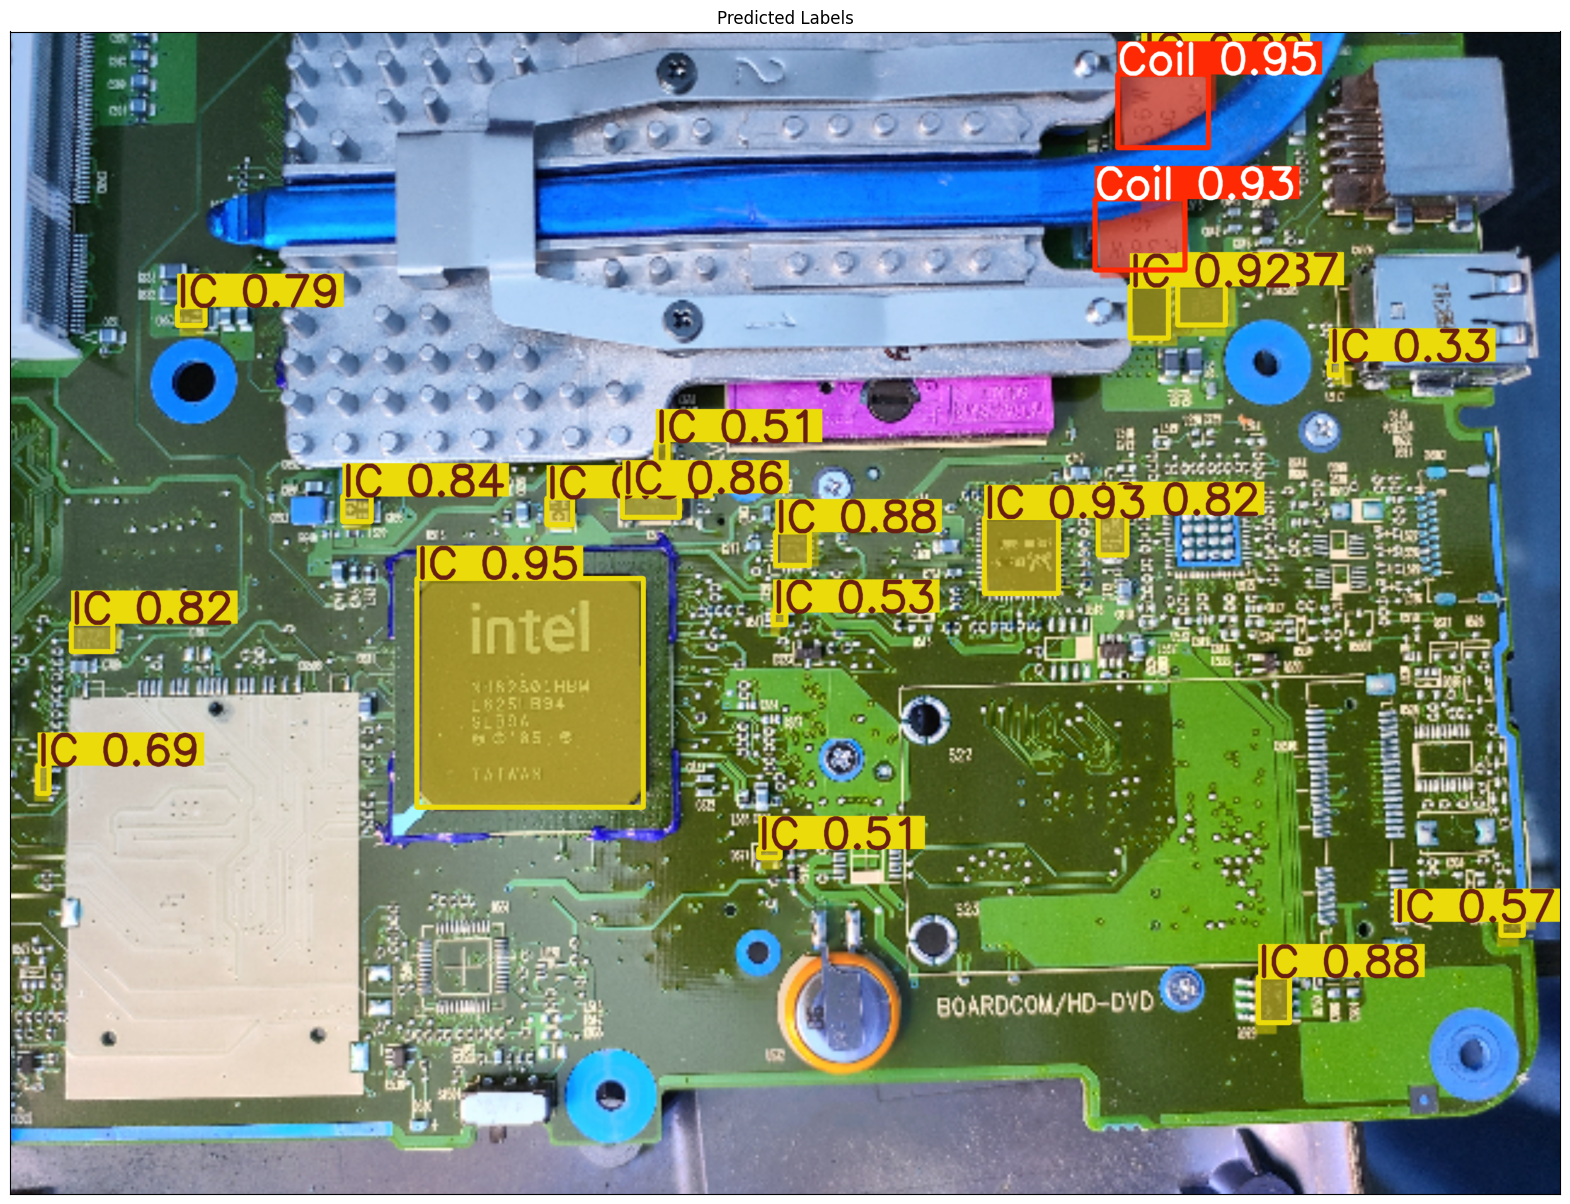

In [2]:
try:
    model = YOLO('160p500es-seg.pt')
except Exception as e:
    print(f"Error loading YOLO model: {e}")
try:
    image = cv2.imread('test.jpg')
    if image is None:
        print(f"Error: Could not load image")

    # Perform inference
    results = model(image, verbose=False)

    # Annotate the image
    annotated_image = results[0].plot()

    # Plot the findings
    plt.figure(figsize=(20, 20))
    plt.title('Predicted Labels'), plt.xticks([]), plt.yticks([])
    plt.imshow(annotated_image)
    # display that image
    plt.show()

except Exception as e:
    print(f"Error processing picture: {e}")

I will find the IC with biggest area. For this, I will have to iterate over results and find prediction polygons, and then calculate area of the polygon.

In [3]:
largest_mask_area = 0
largest_mask_points = None
largest_mask_index = -1 # To keep track of which mask it was

# Process results for each detected object
for result in results:
    if result.masks is not None:
        for i, mask_points in enumerate(result.masks.xy):
            # Calculate the area of the current polygon
            # OpenCV's contourArea function is good for this
            # It expects a 2D array of points, so reshape mask_points
            
            # Convert mask_points to a NumPy array for cv2.contourArea
            current_polygon = np.array(mask_points, dtype=np.float32)
            
            # Calculate the area
            # The contourArea function calculates the signed area, so we take the absolute value.
            area = cv2.contourArea(current_polygon)

            # Check if this mask's area is larger than the current largest
            if area > largest_mask_area:
                largest_mask_area = area
                largest_mask_points = mask_points
                largest_mask_index = i
                
# Now, largest_mask_points contains the points of the largest polygon mask

if largest_mask_points is not None:
    print(f"Largest mask found with area: {largest_mask_area:.2f}")
    print(f"Index of largest mask: {largest_mask_index}")

    # Convert the largest mask points to a numpy array of integers
    points = np.int32([largest_mask_points])
    
    rect = cv2.boundingRect(points)
    x,y,w,h = rect
    cropped = image[y:y+h, x:x+w].copy()

    # # Create a blank mask image (same size as original image)
    # mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # # Fill the polygon on the mask
    # cv2.fillPoly(mask, points, 255) # Fill with white (255) to represent the segmented area

    # # Extract the segmented region from the original image
    # segmented_region = np.zeros_like(image)
    # segmented_region = cv2.bitwise_and(image, image, mask=mask)
    
    if cropped.size > 0:
        cv2.imshow("Cropped Largest Segmented Region", cropped)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
else:
    print("No masks found in the detection results.")

Largest mask found with area: 330419.25
Index of largest mask: 0


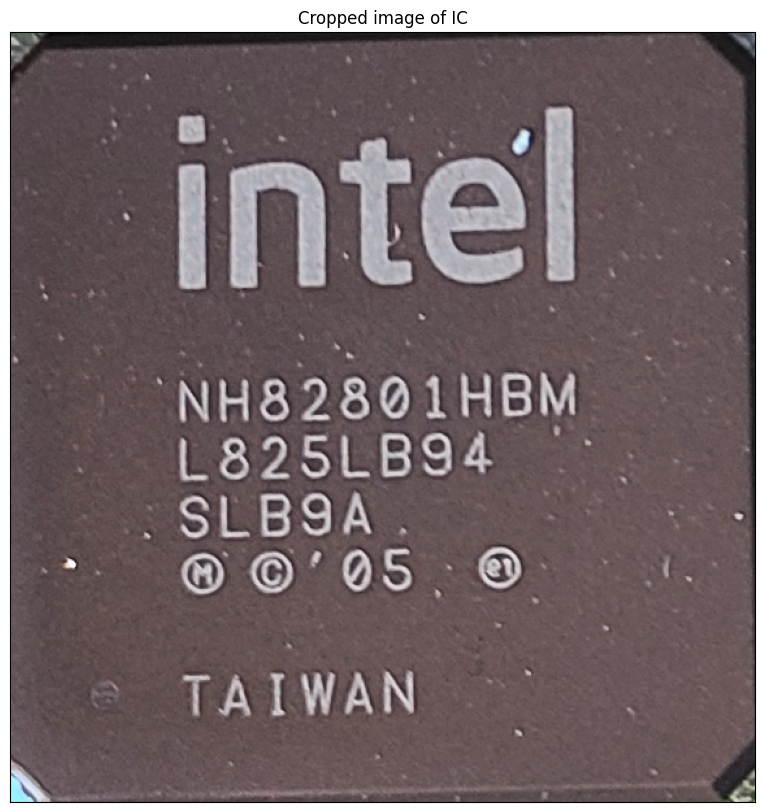

In [4]:
plt.figure(figsize=(10, 10))
plt.title('Cropped image of IC'), plt.xticks([]), plt.yticks([])
plt.imshow(cropped)
# display that image
plt.show()

In [5]:
def preprocess_for_ocr(image):
    # 1. Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Denoising (Non-local Means is good for text)
    # Adjust h, hForColorComponents, templateWindowSize, searchWindowSize based on noise level
    denoised = cv2.fastNlMeansDenoising(gray, None, h=20, templateWindowSize=7, searchWindowSize=21)

    # 3. Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_enhanced = clahe.apply(denoised)

    kernel1 = np.ones((99,99),np.uint8)
    kernel2 = np.ones((3,3),np.uint8)

    tophat_image = cv2.morphologyEx(clahe_enhanced, cv2.MORPH_TOPHAT, kernel1)

    dilated = cv2.dilate(tophat_image,kernel2, iterations = 1)

    # 4. Adaptive Binarization
    # Experiment with blockSize and C. Smaller blockSize for smaller text.
    # binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                cv2.THRESH_BINARY_INV, 99, 5) # Block size (odd), C (subtract from mean)

    _, binary = cv2.threshold(tophat_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Invert if text is white on black (Tesseract usually expects black text on white background)
    # Check if dominant color is black or white. If most pixels are 255, invert.
    if np.mean(binary) > 127: # If image is mostly white (text is black)
        pass # No inversion needed
    else: # If image is mostly black (text is white)
        binary = cv2.bitwise_not(binary)

    # Optional: Sharpening (can sometimes help, sometimes hurt)
    # kernel = np.array([[0, -1, 0],
    #                    [-1, 5, -1],
    #                    [0, -1, 0]], dtype=np.float32)
    # sharpened = cv2.filter2D(binary, -1, kernel)
    # return sharpened
    return binary

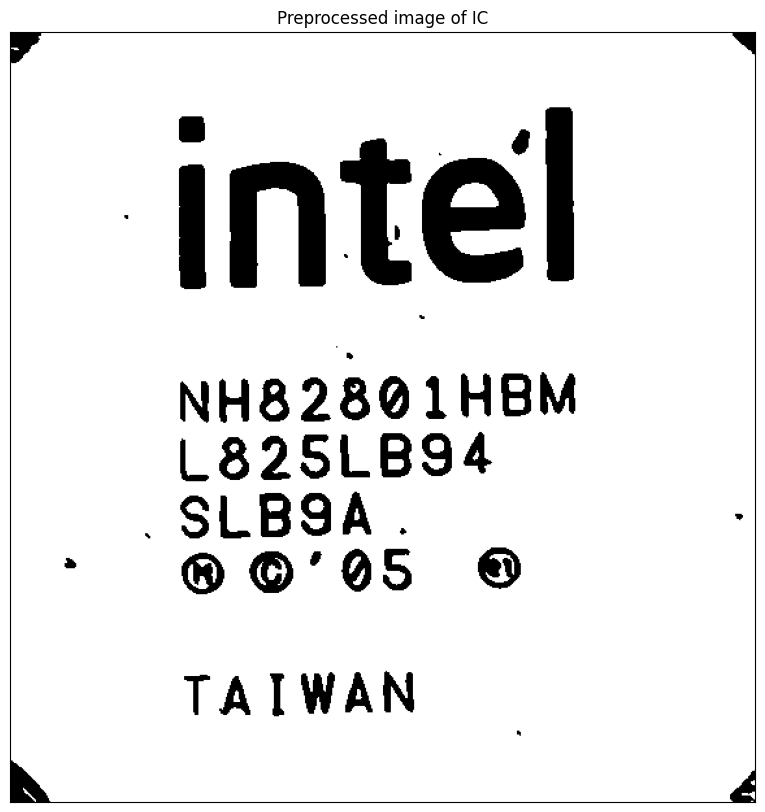

In [6]:
processed_image = preprocess_for_ocr(cropped)

plt.figure(figsize=(10, 10))
plt.title('Preprocessed image of IC'), plt.xticks([]), plt.yticks([])
plt.imshow(processed_image, cmap='gray')
# display that image
plt.show()

In [7]:
cv2.imwrite('detect.png', processed_image)
cv2.imwrite('cropped.png', cropped)

True

After experimentation, PadleOCR showed the best results, even without preprocessing. So it will be choosen as the OCR model for identifying IC chips

In [8]:
ocr = PaddleOCR(
    use_doc_orientation_classify=False, 
    use_doc_unwarping=False, 
    use_textline_orientation=False)
result = ocr.predict('cropped.png')
for res in result:
    res.print()
    res.save_to_img("output")
    res.save_to_json("output")

which: no ccache in (/home/ign/coding/ocr/.venv/bin:/home/ign/.bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl)
/home/ign/coding/ocr/.venv/lib/python3.13/site-packages/paddle/utils/cpp_extension/extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /home/ign/.paddlex/official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 343.79it/s]
Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /home/ign/.paddlex/official_models.
Fetching 6 files: 100%|█████